### We used the python code from the GitHub repository "https://github.com/SysBioChalmers/DLKcat" to reproduce the DLKcat model and to make predictions for their test set:

In [1]:
import numpy as np
import pandas as pd
from os.path import join
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('CCB_plot_style_0v4.mplstyle');
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

from Bio import pairwise2
from Bio.Emboss.Applications import NeedleCommandline

import pickle
import torch

def load_tensor(file_name, dtype):
    return [dtype(d).to(device) for d in np.load(file_name + '.npy', allow_pickle=True)]


def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def shuffle_dataset(dataset, seed):
    np.random.seed(seed)
    np.random.shuffle(dataset)
    return dataset

def split_dataset(dataset, ratio):
    n = int(ratio * len(dataset))
    dataset_1, dataset_2 = dataset[:n], dataset[n:]
    return dataset_1, dataset_2

def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

device = "cpu"


Bad key text.latex.preview in file CCB_plot_style_0v4.mplstyle, line 55 ('text.latex.preview  : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file CCB_plot_style_0v4.mplstyle, line 63 ('mathtext.fallback_to_cm : True ## When True, use symbols from the Computer Modern fonts')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


## 1. Loading results from DLKcat prediction

In [ ]:
with open(join( "..", "data", "DLKcat", "sequences_test.pkl"), 'rb') as f:
    sequences_test = pickle.load(f)
    
with open(join("..", "data", "DLKcat", 'sequences_train.pkl'), 'rb') as f:
    sequences_train = pickle.load(f)
    
with open(join( "..", "data", "DLKcat", 'sequences_dev.pkl'), 'rb') as f:
    sequences_dev = pickle.load(f)
    
with open(join( "..", "data", "DLKcat", 'y_pred_test.pkl'), 'rb') as f:
    y_test_pred = pickle.load(f)

interactions = load_tensor(join("..", "data", "DLKcat", 'regression'), torch.FloatTensor)
interactions = shuffle_dataset(interactions, 1234)
interactions_train, interactions_ = split_dataset(interactions, 0.8)
interactions_dev, interactions_test = split_dataset(interactions_, 0.5)

#converting kcat values from log2 to log10:
interactions_test = [np.log10(2**float(kcat)) for kcat in interactions_test]
interactions_dev = [np.log10(2**float(kcat)) for kcat in interactions_dev]
interactions_train = [np.log10(2**float(kcat)) for kcat in interactions_train]

df_pred = pd.DataFrame({"y_true" : interactions_test, "y_pred" : y_test_pred, "Sequence" : sequences_test})
data_train = pd.DataFrame({"y_true" : interactions_train, "Sequence" : sequences_train})
df_val = pd.DataFrame({"y_true" : interactions_dev, "Sequence" : sequences_dev})
df_pred

y_true    y_pred                                           Sequence
0    -2.207608 -0.071899  MSAIDCIITAAGLSSRMGQWKMMLPWEQGTILDTSIKNALQFCSRI...
1    -3.657577 -2.707640  MKEFYLTVEQIGDSIFERYIDSNGRERTREVEYKPSLFAHCPESQA...
2     0.949390  0.831021  MSPSKMNATVGSTSEVEQKIRQELALSDEVTTIRRNAPAAVLYEDG...
3     1.672098  1.513026  MKNVGFIGWRGMVGSVLMQRMVEERDFDAIRPVFFSTSQLGQAAPS...
4    -1.790485 -2.830310  MATSTETISSLAQPFVHLENPINSPLVKETIRPRNDTTITPPPTQW...
...        ...       ...                                                ...
1679 -1.920819 -0.281649  MNYPAEPFRIKSVETVSMIPRDERLKKMQEAGYNTFLLNSKDIYID...
1680  2.740363  0.945056  MIEADYLVIGAGIAGASTGYWLSAHGRVVVLEREAQPGYHSTGRSA...
1681  1.198657  1.115256  MNLREKYGEWGLILGATEGVGKAFCEKIAAGGMNVVMVGRREEKLN...
1682  0.740363  0.917627  MALLSQAGGSYTVVPSGVCSKAGTKAVVSGGVRNLDVLRMKEAFGS...
1683  1.501059  1.663697  MDFYYLPGSAPCRAVQMTAAAVGVELNLKLTNLMAGEHMKPEFLKI...

[1684 rows x 3 columns]

Calculating RMSE and coefficient of determination R²

In [ ]:
np.sqrt(mean_squared_error(interactions_test,y_test_pred)), r2_score(interactions_test,y_test_pred)

(1.1195636742162083, 0.44447253110852536)

In [ ]:
#load json file as pandas dataframe:
with open(join("..", "data", "DLKcat", "Kcat_combination_0918_wildtype_mutant.json"), 'r') as f:
    df_json = pd.read_json(f)
df_json

#round column "value" to one decimal:
df_json["Value"] = df_json["Value"].apply(lambda x: round(x, 3))
df_json


ECNumber                 Organism  \
0        4.2.3.4      Actinidia chinensis   
1        4.2.3.4     Aspergillus nidulans   
2        4.2.3.4        Neurospora crassa   
3      2.1.1.255  Streptomyces coelicolor   
4      2.1.1.255  Streptomyces coelicolor   
...          ...                      ...   
17005   1.1.1.82                 Zea mays   
17006   1.1.1.82                 Zea mays   
17007   1.1.1.82                 Zea mays   
17008   1.1.1.82        Spinacia oleracea   
17009   1.1.1.82        Spinacia oleracea   

                                                  Smiles  \
0                  C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O   
1         C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-]   
2                  C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O   
3      C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...   
4                 CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C   
...                                                  ...   
17005  C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...   
17006                                C(C(C(=O)O)O)C(=O)O   
17007  C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...   
17008                                C(C(C(=O)O)O)C(=O)O   
17009  C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...   

                                             Substrate  \
0      3-deoxy-D-arabino-heptulosonic acid 7-phosphate   
1          3-deoxy-D-arabino-heptulosonate 7-phosphate   
2      3-deoxy-D-arabino-heptulosonic acid 7-phosphate   
3                              S-Adenosyl-L-methionine   
4                      (E)-2-Methylgeranyl diphosphate   
...                                                ...   
17005                                            NADPH   
17006                                         L-Malate   
17007                                            NADP+   
17008                                         L-Malate   
17009                                            NADP+   

                                                Sequence      Type    Value  \
0      MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...  wildtype   20.100   
1      MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...  wildtype    6.800   
2      MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...  wildtype   19.000   
3      MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...  wildtype    0.007   
4      MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...  wildtype    0.039   
...                                                  ...       ...      ...   
17005  MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...  wildtype  955.000   
17006  MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...  wildtype    2.900   
17007  MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...  wildtype    2.900   
17008  MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...  wildtype    6.700   
17009  MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...  wildtype    6.000   

         Unit  
0      s^(-1)  
1      s^(-1)  
2      s^(-1)  
3      s^(-1)  
4      s^(-1)  
...       ...  
17005  s^(-1)  
17006  s^(-1)  
17007  s^(-1)  
17008  s^(-1)  
17009  s^(-1)  

[17010 rows x 8 columns]

In [ ]:
wildtype_seqs = df_json["Sequence"].loc[df_json["Type"] == "wildtype"].values
mutant_seqs = df_json["Sequence"].loc[df_json["Type"] == "mutant"].values
df_pred["Type"] = df_pred["Sequence"].apply(lambda x: "wildtype" if x in wildtype_seqs else "mutant")

### Add substrate names to data points:

In [ ]:
df_pred["Value"] = 10**df_pred["y_true"]
df_pred["Value"] = df_pred["Value"].apply(lambda x: round(x, 3))

df_pred["substrate"] = ""

for ind in df_pred.index:
    seq = df_pred["Sequence"][ind]
    Value = df_pred["Value"][ind]
    help_df = df_json.loc[df_json["Sequence"] == seq]
    help_df = help_df.loc[help_df["Value"] == Value]
    if len(help_df) > 0:
        df_pred["substrate"][ind] = help_df["Substrate"].values[0]
    else:
        df_pred["substrate"][ind] = "unknown"

/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/4142452953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["substrate"][ind] = help_df["Substrate"].values[0]
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/4142452953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["substrate"][ind] = help_df["Substrate"].values[0]
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/4142452953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
data_train["Value"] = 10**data_train["y_true"]
data_train["Value"] = data_train["Value"].apply(lambda x: round(x, 3))

data_train["Substrate"] = ""
for ind in data_train.index:
    seq = data_train["Sequence"][ind]
    Value = data_train["Value"][ind]
    help_df = df_json.loc[df_json["Sequence"] == seq]
    help_df = help_df.loc[help_df["Value"] == Value]
    if len(help_df) > 0:
        data_train["Substrate"][ind] = help_df["Substrate"].values[0]
    else:
        data_train["Substrate"][ind] = "unknown"

/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/241256919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["Substrate"][ind] = help_df["Substrate"].values[0]
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/241256919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["Substrate"][ind] = help_df["Substrate"].values[0]
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/241256919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

## 2. Calculating the maximal sequence identity compared to all sequences in the training set:

#### (a) Creating Fasta files for all training and test sequences:

In [ ]:
'''for ind in df_pred.index:
    ofile = open(join( "..", "data", "DLKcat", "Fasta_files", "test_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_" + str(ind) + "\n" + df_pred["Sequence"][ind] + "\n")
    ofile.close()
    
for ind in range(len(sequences_train)):
    ofile = open(join("..", "data", "DLKcat", "Fasta_files", "train_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_train_" + str(ind) + "\n" + sequences_train[ind] + "\n")
    ofile.close()''';

#### (b) Calculating the maximal pairwise sequence identity:

In [ ]:
'''from Bio.Emboss.Applications import NeedleCommandline
import os
from os.path import join
import pandas as pd
import sys
import time
import numpy as np


arg = int(sys.argv[1])

    
def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)


identities = []
for i in range(13470):
    ident = calculate_identity(
                fasta_file_1 = join("..", "..", "data", "DLKcat", "Fasta_files", "test_seq_" + str(arg) + ".fasta"),
               fasta_file_2 = join("..", "..", "data", "DLKcat", "Fasta_files", "train_seq_" + str(i) + ".fasta"))
    identities.append(ident)


ofile = open(join("..", "..", "data", "DLKcat", "DLkcat_ident", "test_seq" + str(arg) + ".txt"), "w")
ofile.write(str(max(identities)))
ofile.close()''';

Loading the results:

In [ ]:
df_pred["max_ident"] = np.nan

for ind in df_pred.index:
    try:
        with open(join( "..", "data", "DLKcat", "DLkcat_ident", "test_seq" + str(ind) + ".txt")) as f:
            ident = f.readlines()
            ident = float(ident[0])
        df_pred["max_ident"][ind] = ident
    except FileNotFoundError:
        pass
df_pred

/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/3650761389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["max_ident"][ind] = ident
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/3650761389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["max_ident"][ind] = ident
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/3650761389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/3650761389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["max_ident"][ind] = ident
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/3650761389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["max_ident"][ind] = ident
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/3650761389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

y_true    y_pred                                           Sequence  \
0    -2.207608 -0.071899  MSAIDCIITAAGLSSRMGQWKMMLPWEQGTILDTSIKNALQFCSRI...   
1    -3.657577 -2.707640  MKEFYLTVEQIGDSIFERYIDSNGRERTREVEYKPSLFAHCPESQA...   
2     0.949390  0.831021  MSPSKMNATVGSTSEVEQKIRQELALSDEVTTIRRNAPAAVLYEDG...   
3     1.672098  1.513026  MKNVGFIGWRGMVGSVLMQRMVEERDFDAIRPVFFSTSQLGQAAPS...   
4    -1.790485 -2.830310  MATSTETISSLAQPFVHLENPINSPLVKETIRPRNDTTITPPPTQW...   
...        ...       ...                                                ...   
1679 -1.920819 -0.281649  MNYPAEPFRIKSVETVSMIPRDERLKKMQEAGYNTFLLNSKDIYID...   
1680  2.740363  0.945056  MIEADYLVIGAGIAGASTGYWLSAHGRVVVLEREAQPGYHSTGRSA...   
1681  1.198657  1.115256  MNLREKYGEWGLILGATEGVGKAFCEKIAAGGMNVVMVGRREEKLN...   
1682  0.740363  0.917627  MALLSQAGGSYTVVPSGVCSKAGTKAVVSGGVRNLDVLRMKEAFGS...   
1683  1.501059  1.663697  MDFYYLPGSAPCRAVQMTAAAVGVELNLKLTNLMAGEHMKPEFLKI...   

          Type    Value                         substrate  max_ident  
0     wildtype    0.006                               CTP       22.8  
1       mutant    0.000                              dTTP      100.0  
2     wildtype    8.900                               CTP      100.0  
3       mutant   47.000        L-Aspartate 4-semialdehyde      100.0  
4       mutant    0.016  trans,trans-Farnesyl diphosphate       99.4  
...        ...      ...                               ...        ...  
1679    mutant    0.012               3-fluoro-L-tyrosine      100.0  
1680  wildtype  550.000                          L-Lysine      100.0  
1681  wildtype   15.800            7-ketolithocholic acid      100.0  
1682    mutant    5.500                        L-Cysteine       99.8  
1683    mutant   31.700       1-Chloro-2,4-dinitrobenzene      100.0  

[1684 rows x 7 columns]

In [ ]:
data_test = df_pred.copy()

data_test = data_test.loc[data_test["Type"] != "wildtype"]
data_test = data_test.loc[data_test["max_ident"] >99]

def get_train_seq(ind):
    ofile = open(join( "..", "data", "DLKcat", "Fasta_files", 
                      "train_seq_" + str(ind) + ".fasta"), "r")
    return(ofile.readlines()[1].replace("\n", ""))

data_test["kcat_group"] = np.nan

for ind in data_test.index:
    substrate = data_test["substrate"][ind]
    try:
        with open(join("..", "data", "DLKcat", "kcat_similar_DLkcat", "test_seq" + str(ind) + ".txt")) as f:
            ident = f.readlines()
            indices = ident[0].split(" ")
            indices = [int(float(k)) for k in indices[1:]]
            
            kcats = []
            Sequences = [get_train_seq(k) for k in indices]
            for seq in Sequences:
                help_df = data_train.loc[data_train["Sequence"] == seq]
                help_df = help_df.loc[help_df["Substrate"] == substrate]
                kcats = kcats + list(np.log10(help_df["Value"].values))
        data_test["kcat_group"][ind] = np.mean(kcats[:3])
    except:
        pass
#remove inf and -inf entries:
data_test = data_test.replace([np.inf, -np.inf], np.nan)

#remove all nan entries:
data_test = data_test.dropna()
data_test


/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/543312989.py:26: RuntimeWarning: divide by zero encountered in log10
  kcats = kcats + list(np.log10(help_df["Value"].values))
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/543312989.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["kcat_group"][ind] = np.mean(kcats[:3])
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/543312989.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["kcat_group"][ind] = np.mean(kcats[:3])
/var/folders/pt/rdxkfpyn5j70mltf0kpfq9p40000gp/T/ipykernel_22441/543312989.py:

y_true    y_pred                                           Sequence  \
3     1.672098  1.513026  MKNVGFIGWRGMVGSVLMQRMVEERDFDAIRPVFFSTSQLGQAAPS...   
8     1.241795  1.311668  MSLGIRYLALLPLFVITACQQPVNYNPPATQVAQVQPAIVNNSWIE...   
10   -1.148742 -1.775721  MSLQYHVLNSIPSTTFLSSTKTTISSSFLTISGSPLNVARDKSRSG...   
11   -0.866461 -0.317950  MAAKDVKFGNDARVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGA...   
13    1.568202  1.747672  MIVKPMVRNNICLNAHPQGCKKGVEDQIEYTKKRITAEVKAGAKAP...   
...        ...       ...                                                ...   
1670 -0.175224 -0.219565  MDTTVPTFSLAELQQGLHQDEFRRCLRDKGLFYLTDCGLTDTELKS...   
1674  3.067071  2.662785  MLNNAMSVVILAAGKGTRMYSDLPAVLHTLAGKAMVQHVIDAANEL...   
1677 -1.649752  0.604768  MNTLIGKTGIVVRNIQRAELDSIDALGRLGVATVHEAQNRKGLLSS...   
1682  0.740363  0.917627  MALLSQAGGSYTVVPSGVCSKAGTKAVVSGGVRNLDVLRMKEAFGS...   
1683  1.501059  1.663697  MDFYYLPGSAPCRAVQMTAAAVGVELNLKLTNLMAGEHMKPEFLKI...   

        Type     Value                           substrate  max_ident  \
3     mutant    47.000          L-Aspartate 4-semialdehyde      100.0   
8     mutant    17.450                          L-Arginine       99.8   
10    mutant     0.071  (E,E,E)-geranylgeranyl diphosphate       99.9   
11    mutant     0.136                                 ATP       99.8   
13    mutant    37.000                       Crotonoyl-CoA      100.0   
...      ...       ...                                 ...        ...   
1670  mutant     0.668                        Penicillin G       99.7   
1674  mutant  1167.000           D-Glucosamine 1-phosphate      100.0   
1677  mutant     0.022   4-Hydroxy-4-methyl-2-oxoglutarate       99.6   
1682  mutant     5.500                          L-Cysteine       99.8   
1683  mutant    31.700         1-Chloro-2,4-dinitrobenzene      100.0   

      kcat_group  
3       1.672098  
8       1.179316  
10     -0.950878  
11     -0.500544  
13      1.959041  
...          ...  
1670   -0.273541  
1674    3.176091  
1677    2.127105  
1682    0.653213  
1683    1.463050  

[653 rows x 8 columns]

/Users/kroll/miniconda3/envs/DL_for_Molecules/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kroll/miniconda3/envs/DL_for_Molecules/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kroll/miniconda3/envs/DL_for_Molecules/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kroll/miniconda3/envs/DL_for_Molecules/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

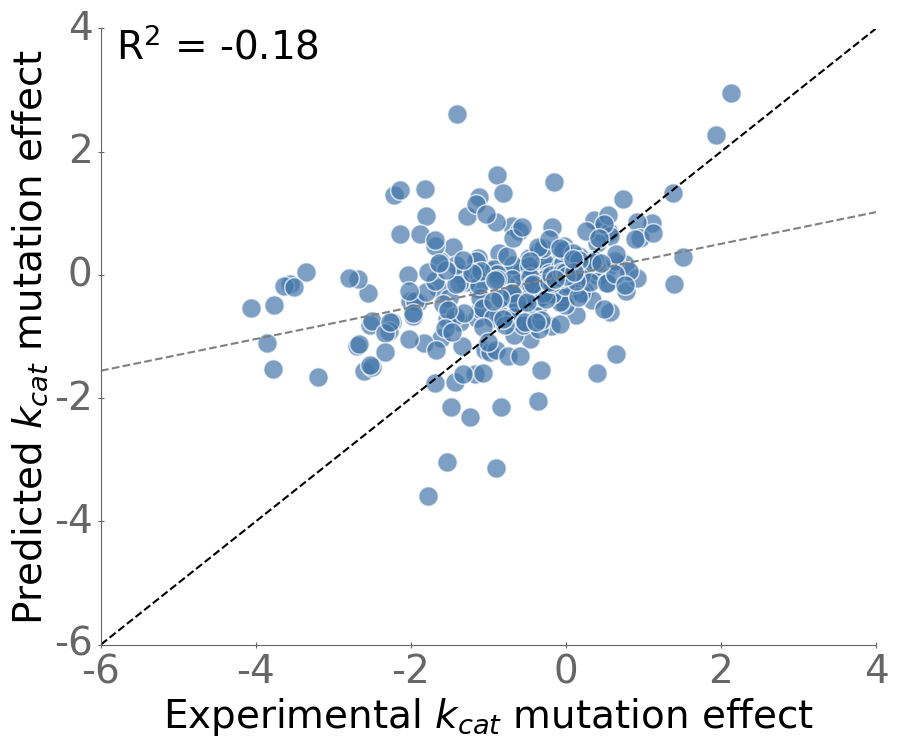

In [ ]:


data_test["delta_pred"] = data_test["y_pred"] - data_test["kcat_group"]
data_test["delta_true"] = data_test["y_true"] - data_test["kcat_group"]


fig, ax = plt.subplots(figsize= (10,8))
plt.rcParams.update({'font.size': 28})


x_min =-6
x_max = 4
y_min = -6
y_max = 4

help_df = data_test.loc[data_test["max_ident"] <100]

sns.scatterplot(x="delta_true", y="delta_pred",  data=help_df, s= 200,alpha=0.7)

r2 = r2_score(help_df["delta_true"], help_df["delta_pred"])
#write r2 on plot in top left corner:
plt.text(x_min + 0.2, y_max - 0.5, "R$^2$ = " + str(round(r2, 2)), fontsize=28)

#plot a line of best fit in red:
slope, intercept, r_value, p_value, std_err = stats.linregress(help_df["delta_true"], help_df["delta_pred"])
sns.lineplot(x=[x_min,x_max],y=[x_min*slope + intercept,x_max*slope + intercept], color = "grey", linestyle='--')

plt.xlabel("Experimental $\it{k}_{cat}$ mutation effect")
plt.ylabel("Predicted $\it{k}_{cat}$ mutation effect")

sns.lineplot(x=[x_min,x_max],y=[y_min,y_max], linestyle='--', color = "black")
#plt.legend(title="Substrate", bbox_to_anchor=(1, 0.5), frameon = True, fontsize=20)

plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

#save plots as figure2a.eps:
plt.savefig(join("..", "data", "DLKcat", "figure2a.eps"), format='eps', bbox_inches = 'tight', dpi=1000)

plt.show()

In [ ]:
data_test.to_pickle(join( "..", "data", "DLKcat", "df_pred.pkl"))

## Calculate model performance for different sequence identities:

In [ ]:
lower_bounds = [0, 40, 80, 99]
upper_bounds = [40,80,99,100]


for i in range(len(lower_bounds)):
    lb, ub = lower_bounds[i], upper_bounds[i]
    help_df = df_pred.loc[df_pred["max_ident"] >=  lb].loc[df_pred["max_ident"] <= ub]
    if len(help_df) > 0:
        y_pred, y_true = np.array(help_df["y_pred"]), np.array(help_df["y_true"])
        R2 =  r2_score(y_true, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
        
        print("Lower bound: %s, upper bound: %s, no. of data points: %s, R2: %s, RMSE: %s" %  (lb, ub, len(help_df), R2, RMSE))

Lower bound: 0, upper bound: 40, no. of data points: 82, R2: -0.6072304105234347, RMSE: 2.0954145982947594
Lower bound: 40, upper bound: 80, no. of data points: 42, R2: 0.34280134977895493, RMSE: 1.2434758603533023
Lower bound: 80, upper bound: 99, no. of data points: 27, R2: 0.48622435213243465, RMSE: 1.1191845445308464
Lower bound: 99, upper bound: 100, no. of data points: 1536, R2: 0.5128517542754034, RMSE: 1.0371892758113466
